### **Real Estate Market Analysis: Exploratory Data Analysis of Zameen.com Listings**

#**Importing Required Libraries**

In [247]:
!pip install fuzzywuzzy python-Levenshtein #installed fuzzywuzzy because there was an error that it wasn't available in python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from fuzzywuzzy import process, fuzz
import warnings
warnings.filterwarnings('ignore')

# **Loading Data**


In [248]:
# Changing the URL format for CSV export
url = 'https://docs.google.com/spreadsheets/d/1KKiAFz__aAS7kuCwqzIIZcoI6lKnew_S/export?format=csv&gid2004884327#gid=2004884327'

# Loading the data
df = pd.read_csv(url)

#**Dataset Information**

In [249]:
# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (18255, 59)

First 5 rows:


,Title,URL,City,Type,Area,Price,Purpose,Location,Description,Built in year,...,Nearby Schools,Nearby Hospitals,Nearby Shopping Malls,Nearby Restaurants,Distance From Airport (kms),Nearby Public Transport Service,Other Nearby Places,Maintenance Staff,Security Staff,Other Facilities
0,Hmr Waterfront 2 Bed Room Premium Apartment On...,https://www.zameen.com/Property/dha_phase_8_hm...,Karachi,Flat,128 Sq. Yd.,PKR\n4.75 Crore,For Sale,"DHA Defence, Karachi, Sindh",SAIMA MARINA RESIDENCE HMR WATERFRONT\nINVESTO...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Chance Deal! Luxury 2 Bedroom Seafront Apartme...,https://www.zameen.com/Property/dha_defence_dh...,Karachi,Flat,161 Sq. Yd.,PKR\n6.25 Crore,For Sale,"DHA Defence, Karachi, Sindh",Live the Seafront Dream at H&S Residence \n2 B...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Luxury 1 Bed At H& S Residence By Japanese Arc...,https://www.zameen.com/Property/dha_phase_8_hm...,Karachi,Flat,111 Sq. Yd.,PKR\n3.45 Crore,For Sale,"DHA Defence, Karachi, Sindh",Live the Seafront Dream at H&S Residence \n1 B...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Luxury 1 Bed Seafront Apartment at HMR waterfr...,https://www.zameen.com/Property/dha_phase_8_hm...,Karachi,Flat,106 Sq. Yd.,PKR\n2.98 Crore,For Sale,"DHA Defence, Karachi, Sindh",Chance Deal at HMR Waterfront 1-Bed Apartment ...,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2 Bed Apartment For Booking On 3 Years | Saima...,https://www.zameen.com/Property/dha_phase_8_hm...,Karachi,Flat,156 Sq. Yd.,PKR\n4.65 Crore,For Sale,"DHA Defence, Karachi, Sindh",HMR WATERFRONT \n\nOwn Your Dream Apartment in...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Checking for Duplicates**

In [250]:
# Checking for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


# **Data Cleaning and Outliers**

In [251]:
def clean_price(price):
    if pd.isna(price):
        return np.nan

    # converting to string
    price_str = str(price).strip().lower()

    # Removing commas, currency symbols and extra spaces
    price_str = re.sub(r'[,\s]', '', price_str)
    price_str = price_str.replace('pkr', '').replace('rs', '').replace('₹', '').replace('$', '')

    # Check for scale indicators and convert accordingly
    scale_multiplier = 1
    if 'crore' in price_str:
        scale_multiplier = 10000000
        price_str = price_str.replace('crore', '')
    elif 'lac' in price_str or 'lakh' in price_str:
        scale_multiplier = 100000
        price_str = price_str.replace('lac', '').replace('lakh', '')
    elif 'thousand' in price_str:
        scale_multiplier = 1000
        price_str = price_str.replace('thousand', '')

    # Extracting numeric value
    match = re.search(r'(\d+(\.\d+)?)', price_str)
    if match:
        numeric_value = float(match.group(1))
        return numeric_value * scale_multiplier
    else:
        return np.nan

# Applying price cleaning
df['Price'] = df['Price'].apply(clean_price)

# first 10 rows of the Price column
print(df['Price'].head(10))

0    47500000.0
1    62500000.0
2    34500000.0
3    29800000.0
4    46500000.0
5    26000000.0
6    67500000.0
7    16800000.0
8    80000000.0
9    44000000.0
Name: Price, dtype: float64


## **Converting into Standard Unit of Measurement**

In [252]:
# conversion function

def convert_to_sqft(area):
    if pd.isna(area):
        return np.nan

    area_str = str(area).lower().replace(',', '').replace(' ', '')

    # different units and convertion
    if 'marla' in area_str:
        num = re.search(r'(\d+(\.\d+)?)', area_str)
        if num:
            return float(num.group(1)) * 272.25  # 1 marla = 272.25 sq ft
    elif 'kanal' in area_str:  # Fixed typo: was 'kana1'
        num = re.search(r'(\d+(\.\d+)?)', area_str)
        if num:
            return float(num.group(1)) * 5445  # 1 kanal = 5445 sq ft
    elif 'sqyd' in area_str or 'yard' in area_str:
        num = re.search(r'(\d+(\.\d+)?)', area_str)
        if num:
            return float(num.group(1)) * 9  # 1 sq yd = 9 sq ft
    else:
        # if it's already in sq ft or extract number
        num = re.search(r'(\d+(\.\d+)?)', area_str)
        if num:
            return float(num.group(1))

    return np.nan

# Now applying the conversion
df['Area_SqFt'] = df['Area'].apply(convert_to_sqft)

# To check the results
print("Original Area values:")
print(df['Area'].head())

print("\nConverted Area_SqFt values:")
print(df['Area_SqFt'].head())

Original Area values:
0    128 Sq. Yd.
1    161 Sq. Yd.
2    111 Sq. Yd.
3    106 Sq. Yd.
4    156 Sq. Yd.
Name: Area, dtype: object

Converted Area_SqFt values:
0    128.0
1    161.0
2    111.0
3    106.0
4    156.0
Name: Area_SqFt, dtype: float64


In [253]:
# Checking for extreme outliers in price
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Price range before outlier treatment: {df['Price'].min()} to {df['Price'].max()}")
print(f"IQR bounds: {lower_bound} to {upper_bound}")

# Limiting extreme outliers
df['Price'] = np.where(df['Price'] > upper_bound, upper_bound, df['Price'])
df['Price'] = np.where(df['Price'] < lower_bound, lower_bound, df['Price'])

print(f"Price range after outlier treatment: {df['Price'].min()} to {df['Price'].max()}")


Price range before outlier treatment: 1.0 to 990000000.0
IQR bounds: -51400000.0 to 86040000.0
Price range after outlier treatment: 1.0 to 86040000.0


In [254]:
# Managing extreme area values

# Before capping (check min/max)
print("Before Capping:")
print("Min Area_SqFt:", df['Area_SqFt'].min())
print("Max Area_SqFt:", df['Area_SqFt'].max())

# Recalculateing bounds
Q1_area = df['Area_SqFt'].quantile(0.25)
Q3_area = df['Area_SqFt'].quantile(0.75)
IQR_area = Q3_area - Q1_area
lower_bound_area = Q1_area - 1.5 * IQR_area
upper_bound_area = Q3_area + 1.5 * IQR_area

# Apply capping
df['Area_SqFt'] = np.where(df['Area_SqFt'] > upper_bound_area, upper_bound_area, df['Area_SqFt'])
df['Area_SqFt'] = np.where(df['Area_SqFt'] < lower_bound_area, lower_bound_area, df['Area_SqFt'])

# After capping (check min/max again)
print("\nAfter Capping:")
print("Min Area_SqFt:", df['Area_SqFt'].min())
print("Max Area_SqFt:", df['Area_SqFt'].max())


Before Capping:
Min Area_SqFt: 0.0
Max Area_SqFt: 245025000.0

After Capping:
Min Area_SqFt: 0.0
Max Area_SqFt: 5172.75


# **Managing Missing Values**

In [255]:
# Checking for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 Title                                 16
Type                                  16
Area                                  16
Price                                 16
Purpose                               16
Location                              16
Description                         3362
Built in year                       6315
Parking Spaces                      8599
Double Glazed Windows              18255
Central Air Conditioning           18255
Central Heating                    18255
Flooring                           18255
Electricity Backup                 18255
Waste Disposal                     18255
Floors                              9889
Other Main Features                18255
Furnished                          18255
Bedrooms                              16
Bathrooms                             16
Servant Quarters                    8598
Drawing Room                       18255
Dining Room                        18255
Kitchens                            4999

In [256]:
print("Missing values in numerical columns:")
print(df[numerical_cols].isnull().sum())

Missing values in numerical columns:
Price                 16
Area_SqFt             16
Bedrooms              16
Bathrooms             16
Kitchens            4999
Parking Spaces      8599
Floors              9889
Servant Quarters    8598
Store Rooms         8536
dtype: int64


In [257]:
# converting all numerical columns to numeric type, handling errors
for col in numerical_cols:
    if col in df.columns:
        # Converting to numeric, forcing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

# to identify columns with missing values
cols_with_missing = df[numerical_cols].columns[df[numerical_cols].isnull().any()].tolist()

for col in cols_with_missing:
    if df[col].notna().any():  # to check if there are any non-null values
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)
    else:
        df[col] = df[col].fillna(0)

In [258]:
print("\nMissing values after imputation:")
print(df[numerical_cols].isnull().sum())


Missing values after imputation:
Price               0
Area_SqFt           0
Bedrooms            0
Bathrooms           0
Kitchens            0
Parking Spaces      0
Floors              0
Servant Quarters    0
Store Rooms         0
dtype: int64


#**Standradizing Cities**

In [259]:
# Getting unique city names
unique_cities = df['City'].unique()
print("Original unique cities:", unique_cities)

# Creating a mapping dictionary for standardization
city_mapping = {}
standard_cities = ['Lahore', 'Karachi', 'Islamabad', 'Rawalpindi', 'Faisalabad',
                   'Multan', 'Peshawar', 'Gujranwala', 'Quetta', 'Sialkot']

for city in unique_cities:
    if pd.isna(city):
        continue

    # Finding the best match from standard cities
    match, score = process.extractOne(str(city), standard_cities, scorer=fuzz.token_set_ratio)

    # If match is close enough, use it
    if score > 80:
        city_mapping[city] = match
    else:
        city_mapping[city] = city  # Keep original if no match

# Applying city standardization
df['City_Standardized'] = df['City'].map(city_mapping)

print("\nStandardized cities:", df['City_Standardized'].unique())

Original unique cities: ['Karachi' 'Islamabad' 'Faisalabad' 'Multan' 'Rawalpindi' 'Peshawar'
 'Jhelum' 'Murree' 'Hyderabad' 'Bahawalpur' 'Sialkot' 'Abbottabad'
 'Sahiwal' 'Lahore' 'Gujrat' 'Wah' 'Sargodha' 'Sheikhupura' 'Chakwal'
 'Naran' 'Nowshera' 'Mardan' 'Chilas' 'Sarai Alamgir' 'Quetta'
 'Rahim Yar Khan' 'Okara' 'Attock' 'Dera Ghazi Khan' 'Taxila' 'Sukkur'
 'Gwadar' 'Kasur' 'Mirpur' 'Haripur' 'Gujar Khan' 'Gharo' 'Mirpur Khas'
 'Swat' 'Daska' 'Sadiqabad' 'Buner' 'Jhang' 'Lalamusa' 'Lodhran'
 'Pakpattan' 'Chiniot' 'Dera Ismail Khan' 'Fateh Jang' 'Burewala'
 'Hafizabad' 'Talagang' 'Vehari' 'Jamshoro' 'Galyat' 'Gujranwala'
 'Kharian' 'Karachi ' 'Islamabad ' 'Faisalabad ' 'Multan ' 'Rawalpindi '
 'Gujranwala ' 'Peshawar ' 'Lahore ' 'Jhelum ' 'Hyderabad ' 'Sialkot  '
 'Murree ' 'Bahawalpur ' 'Abbottabad ' 'Wah ' 'Gujrat ' 'Sahiwal '
 'Sheikhupura ' 'Sargodha ' 'Rahim Yar Khan ' 'Taxila ' 'Mardan '
 'Sarai Alamgir ' 'Nowshera ' 'Okara ' 'Attock ' 'Dera Ghazi Khan ']

Standardized cities

# **Extracting Bedrooms and Bathrooms from Data**

In [260]:
#Extractioning  functions

def extract_bedrooms(text):
    if pd.isna(text):
        return np.nan
    text = str(text).lower()
    patterns = [r'(\d+)\s*bed', r'(\d+)\s*beds', r'(\d+)\s*bhk']
    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            return int(match.group(1))
    return np.nan

def extract_bathrooms(text):
    if pd.isna(text):
        return np.nan
    text = str(text).lower()
    patterns = [r'(\d+)\s*bath', r'(\d+)\s*baths', r'(\d+)\s*washroom']
    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            return int(match.group(1))
    return np.nan

# Applying extractioning

df['Bedrooms'] = df['Description'].apply(extract_bedrooms)
df['Bathrooms'] = df['Description'].apply(extract_bathrooms)

# If bedrooms/bathrooms not found in description, check title
df['Bedrooms'] = df.apply(
    lambda x: x['Bedrooms'] if not pd.isna(x['Bedrooms']) else extract_bedrooms(x['Title']),
    axis=1
)
df['Bathrooms'] = df.apply(
    lambda x: x['Bathrooms'] if not pd.isna(x['Bathrooms']) else extract_bathrooms(x['Title']),
    axis=1
)

# Outlier removal step

# Defining cap
max_bedrooms = 20
max_bathrooms = 20

df['Bedrooms'] = df['Bedrooms'].apply(lambda x: x if pd.isna(x) or (1 <= x <= max_bedrooms) else np.nan)
df['Bathrooms'] = df['Bathrooms'].apply(lambda x: x if pd.isna(x) or (1 <= x <= max_bathrooms) else np.nan)


In [261]:
# Checking results
print("Bedrooms extraction results:")
print(df['Bedrooms'].value_counts(dropna=False))

print("\nBathrooms extraction results:")
print(df['Bathrooms'].value_counts(dropna=False))

Bedrooms extraction results:
Bedrooms
NaN     10966
3.0      1916
5.0      1480
4.0      1258
2.0      1172
6.0       667
1.0       427
7.0       174
8.0       103
9.0        40
10.0       25
12.0       13
11.0        7
14.0        2
15.0        2
16.0        1
13.0        1
17.0        1
Name: count, dtype: int64

Bathrooms extraction results:
Bathrooms
NaN     15493
6.0       773
5.0       489
4.0       475
3.0       360
2.0       242
7.0       157
1.0       100
8.0        93
9.0        37
10.0       19
12.0        6
11.0        5
14.0        2
15.0        2
20.0        1
18.0        1
Name: count, dtype: int64


# **Featuring Engineering**

In [262]:
# Creating new features

# Price per square foot
df['Price_Per_SqFt'] = df['Price'] / df['Area_SqFt']

# Luxury indicator (based on price per sq ft threshold)

df['Luxury_Property'] = df['Price_Per_SqFt'] > df['Price_Per_SqFt'].quantile(0.75)

# Size category

def size_category(area):
    if area < 1000:
        return 'Small'
    elif area < 2000:
        return 'Medium'
    elif area < 5000:
        return 'Large'
    else:
        return 'Very Large'

df['Size_Category'] = df['Area_SqFt'].apply(size_category)

# Displaying features
df[['Price_Per_SqFt', 'Luxury_Property', 'Size_Category']].head()


,Price_Per_SqFt,Luxury_Property,Size_Category
0,371093.750000,True,Small
1,388198.757764,True,Small
2,310810.810811,True,Small
3,281132.075472,True,Small
4,298076.923077,True,Small


# **Univariate Analysis**

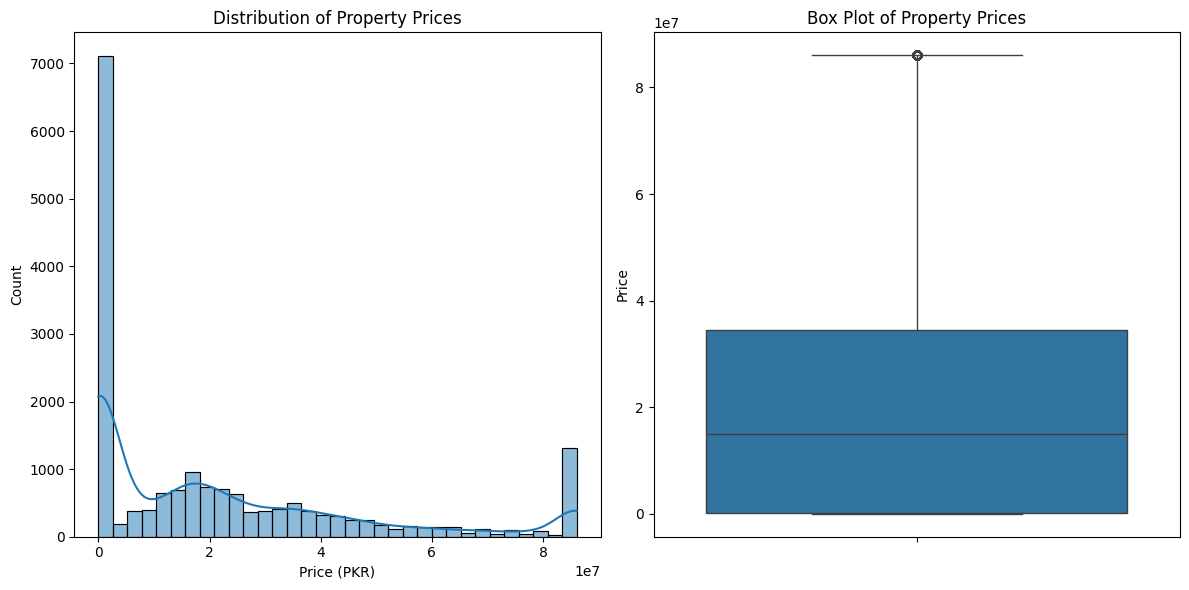

In [263]:
# Distribution of Prices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Property Prices')
plt.xlabel('Price (PKR)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Price'])
plt.title('Box Plot of Property Prices')
plt.tight_layout()
plt.show()


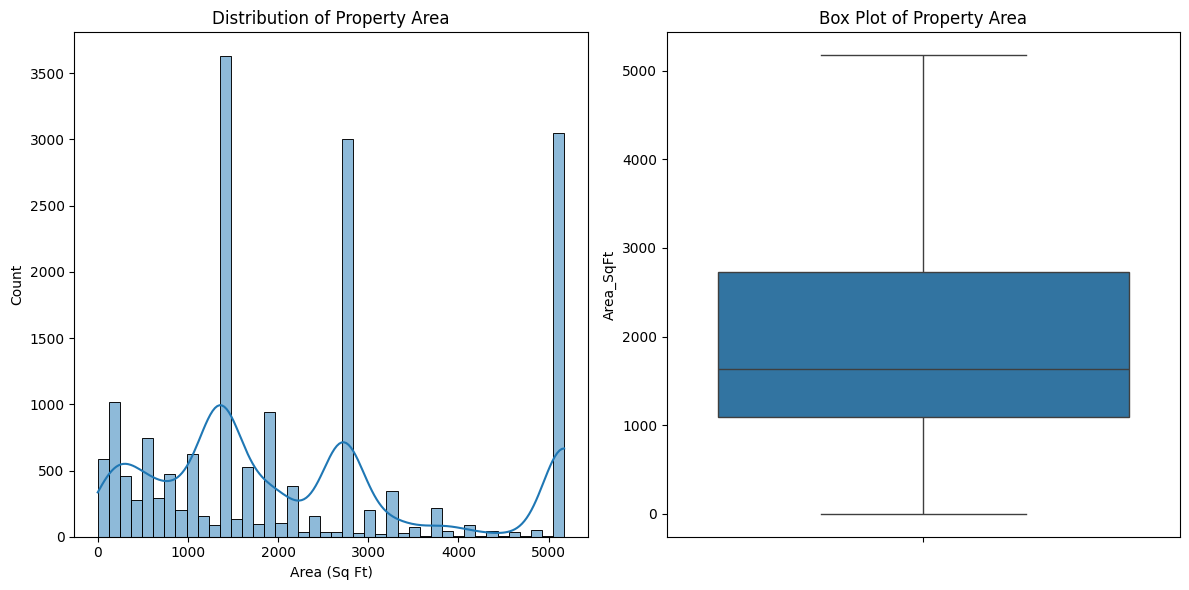

In [264]:
# Distribution of Area
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Area_SqFt'], kde=True)
plt.title('Distribution of Property Area')
plt.xlabel('Area (Sq Ft)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Area_SqFt'])
plt.title('Box Plot of Property Area')
plt.tight_layout()
plt.show()

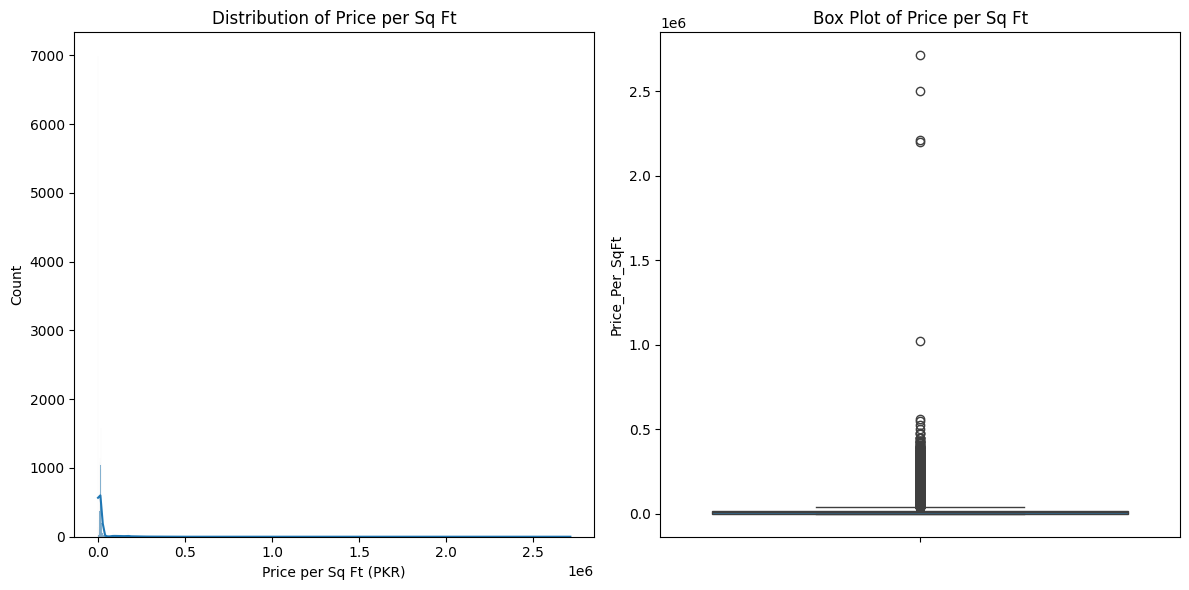

In [265]:
# Distribution of Price per Sq Ft
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Price_Per_SqFt'], kde=True)
plt.title('Distribution of Price per Sq Ft')
plt.xlabel('Price per Sq Ft (PKR)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Price_Per_SqFt'])
plt.title('Box Plot of Price per Sq Ft')
plt.tight_layout()
plt.show()

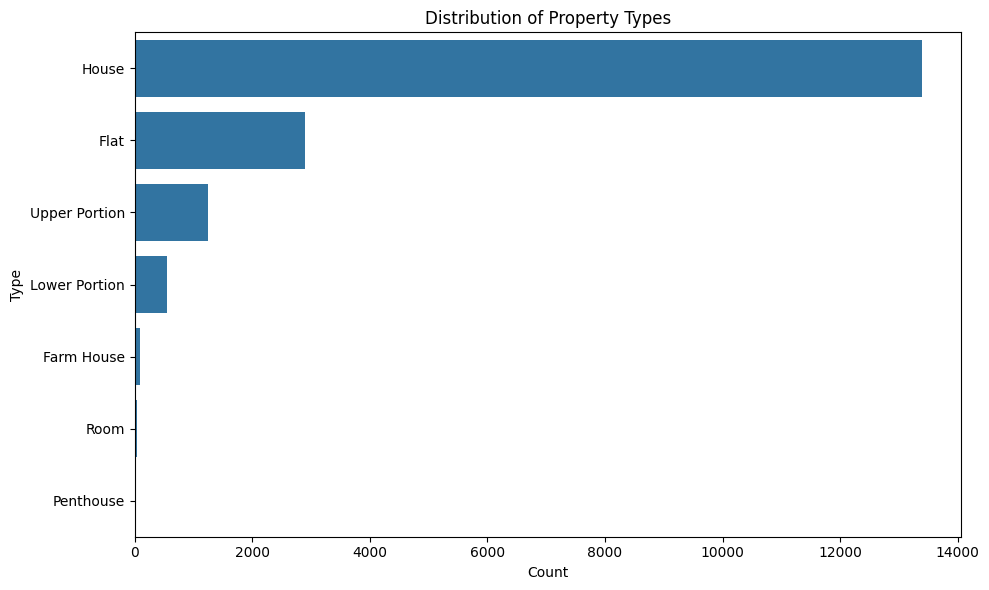

In [266]:
# Property type distribution
plt.figure(figsize=(10, 6))
property_type_counts = df['Type'].value_counts()
sns.barplot(x=property_type_counts.values, y=property_type_counts.index)
plt.title('Distribution of Property Types')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

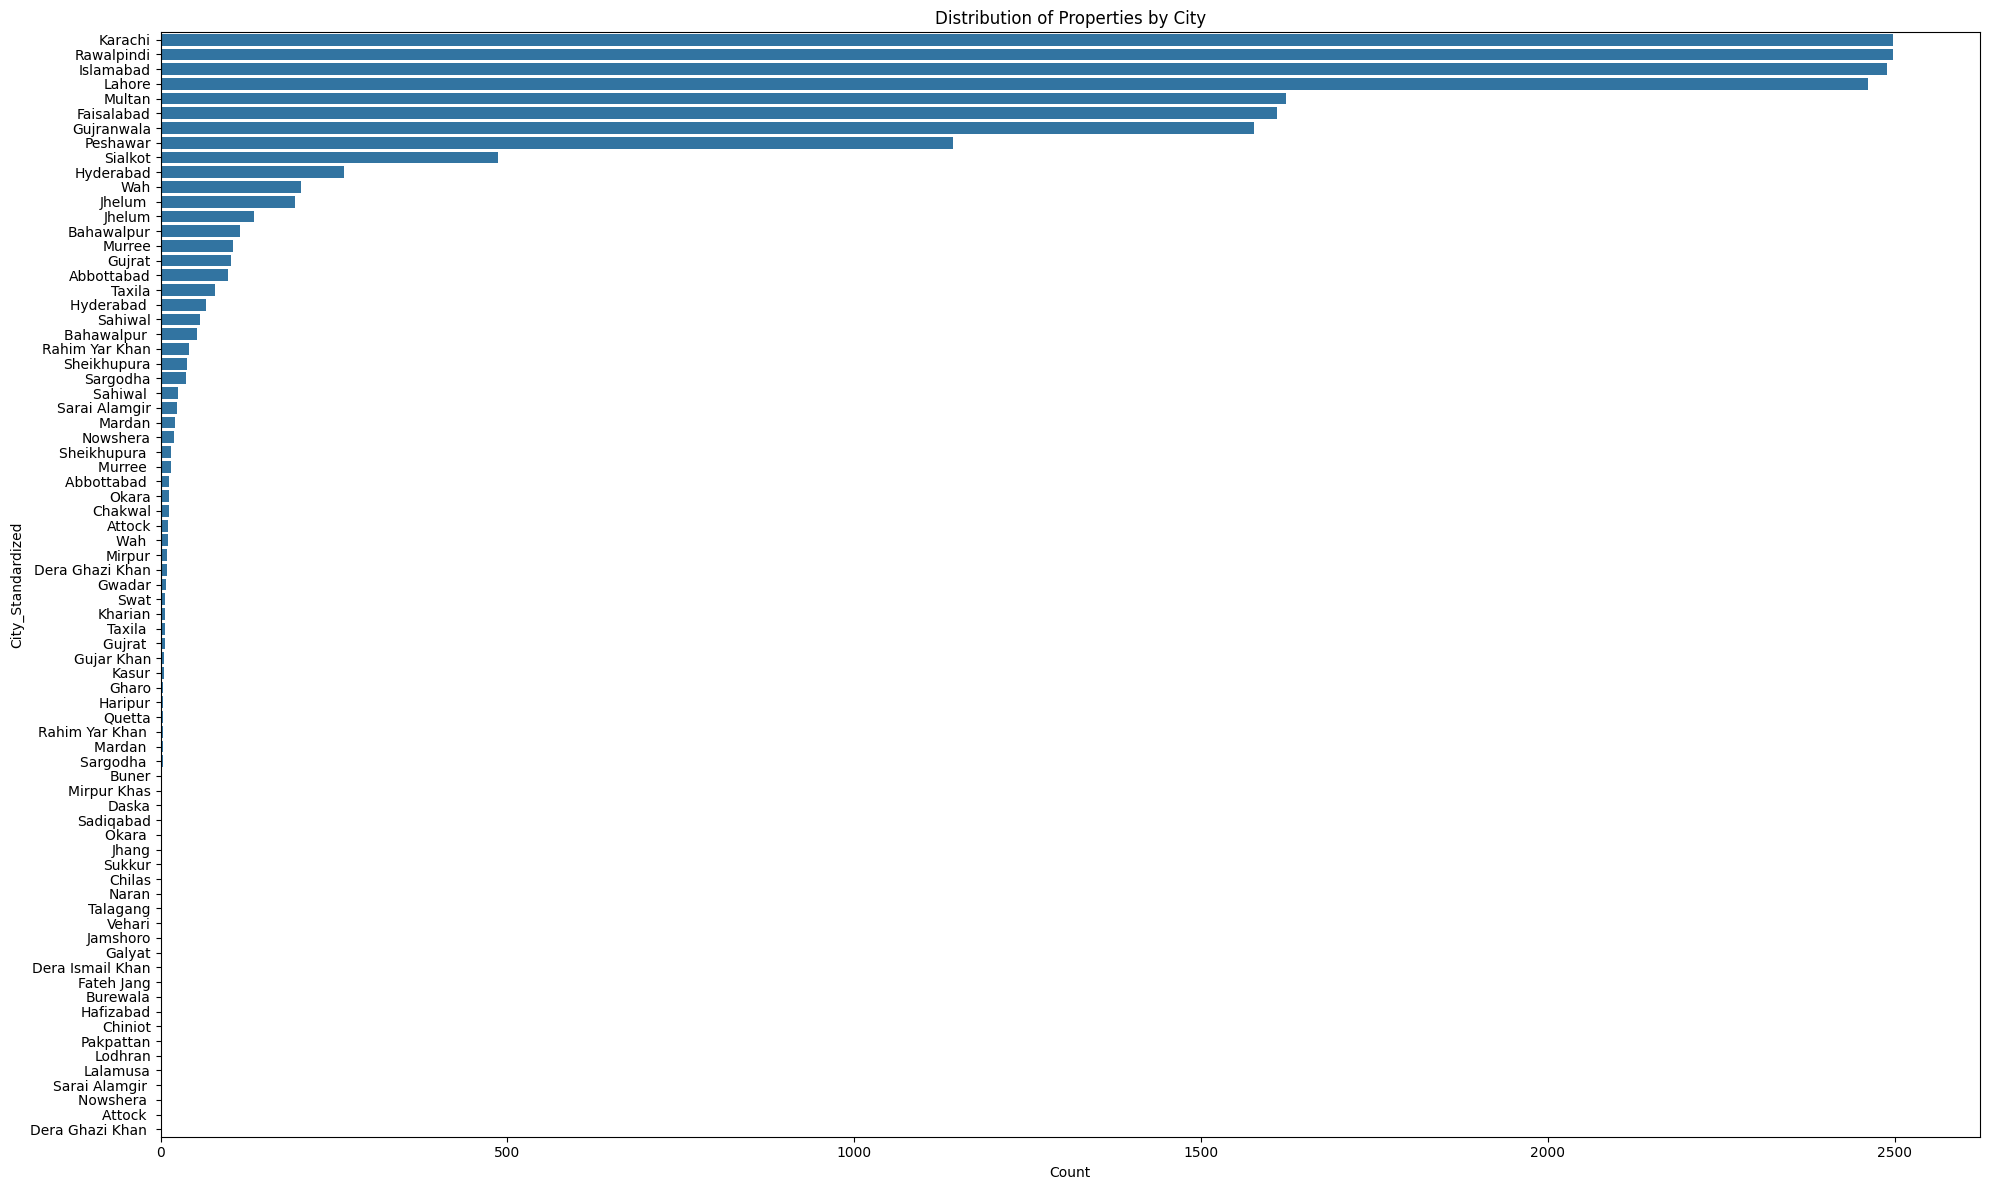

In [267]:
# City distribution
plt.figure(figsize=(20, 12))
city_counts = df['City_Standardized'].value_counts()
sns.barplot(x=city_counts.values, y=city_counts.index)
plt.title('Distribution of Properties by City')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

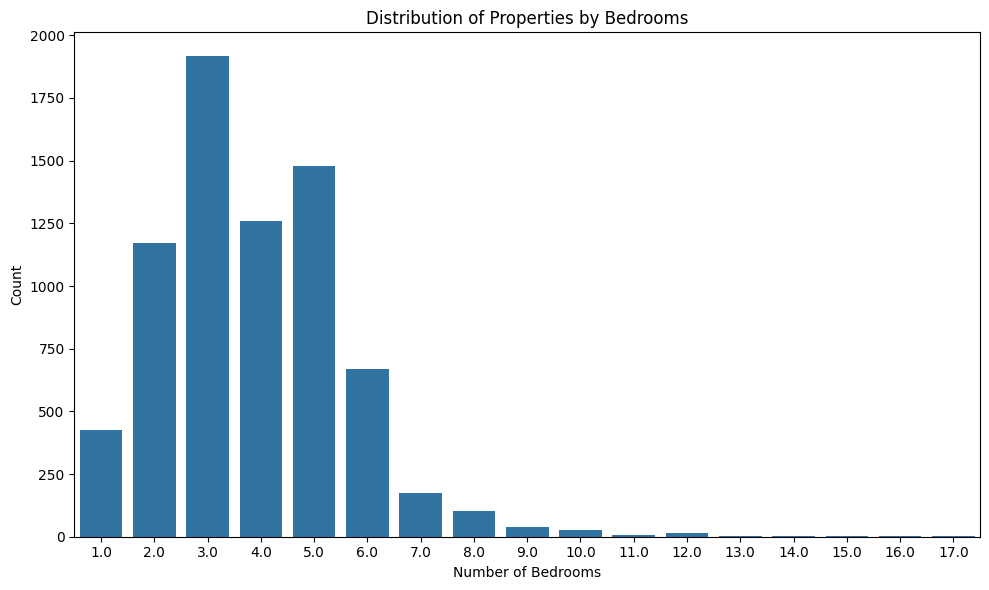

In [268]:
# Bedroom distribution
plt.figure(figsize=(10, 6))
bedroom_counts = df['Bedrooms'].value_counts().sort_index()
sns.barplot(x=bedroom_counts.index, y=bedroom_counts.values)
plt.title('Distribution of Properties by Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# **Bivariate Analysis**

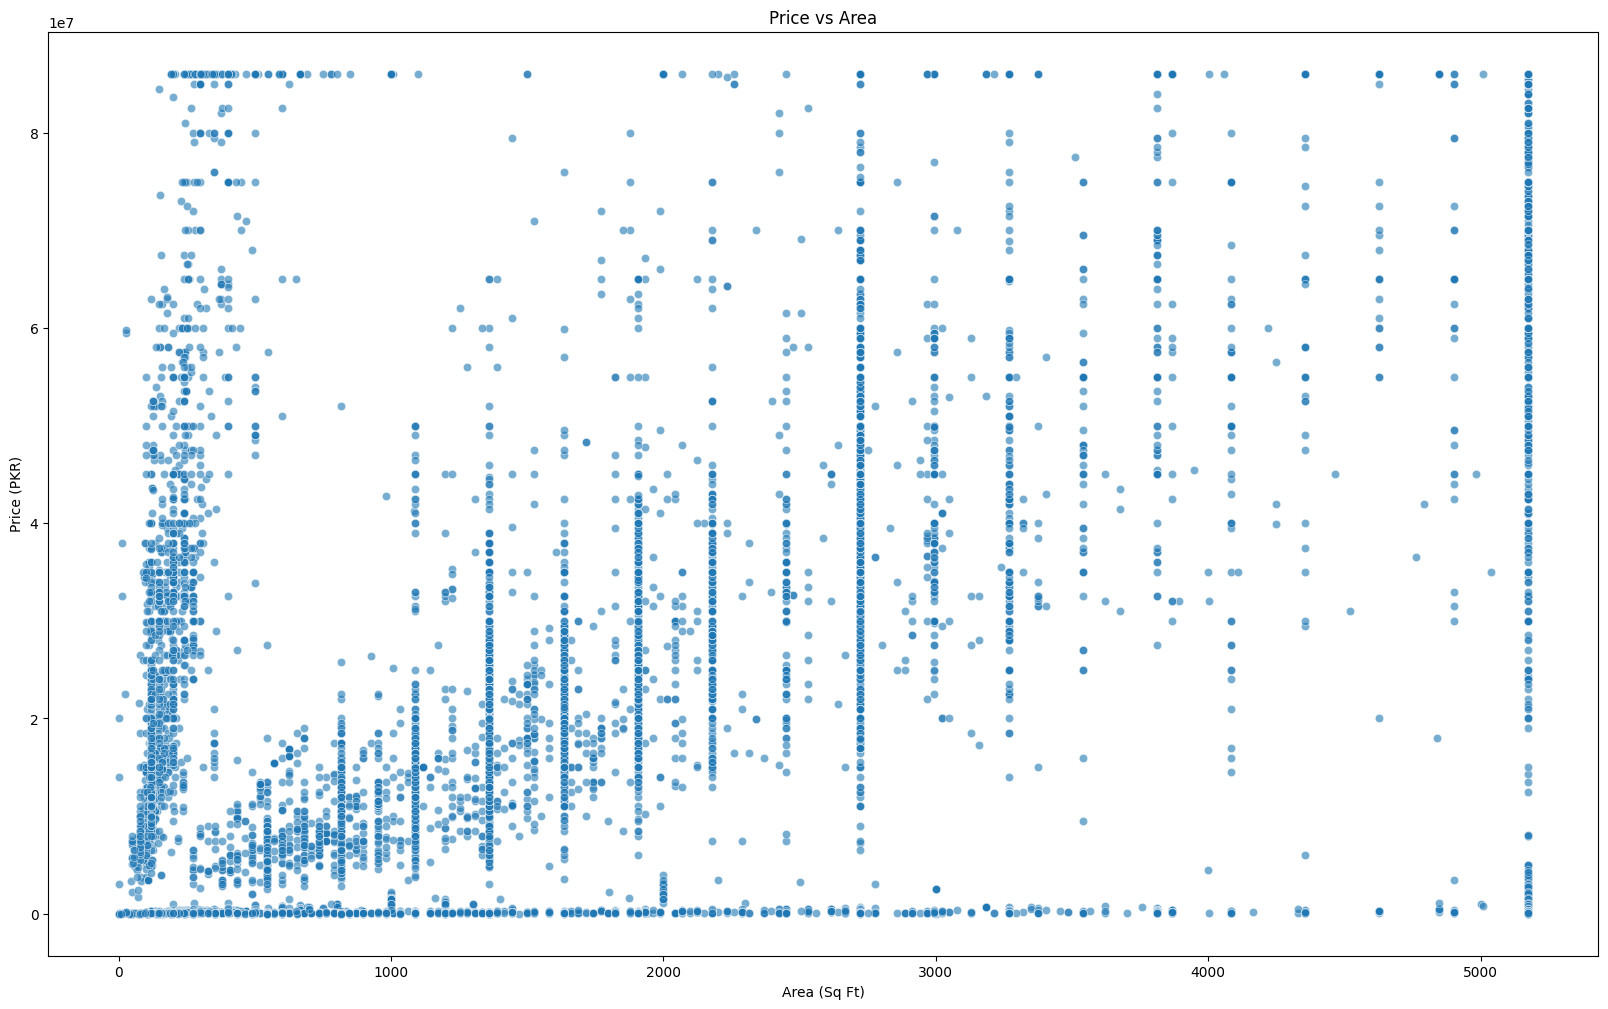

In [269]:
# Price vs Area
plt.figure(figsize=(20, 12))
sns.scatterplot(x=df['Area_SqFt'], y=df['Price'], alpha=0.6)
plt.title('Price vs Area')
plt.xlabel('Area (Sq Ft)')
plt.ylabel('Price (PKR)')
plt.show()

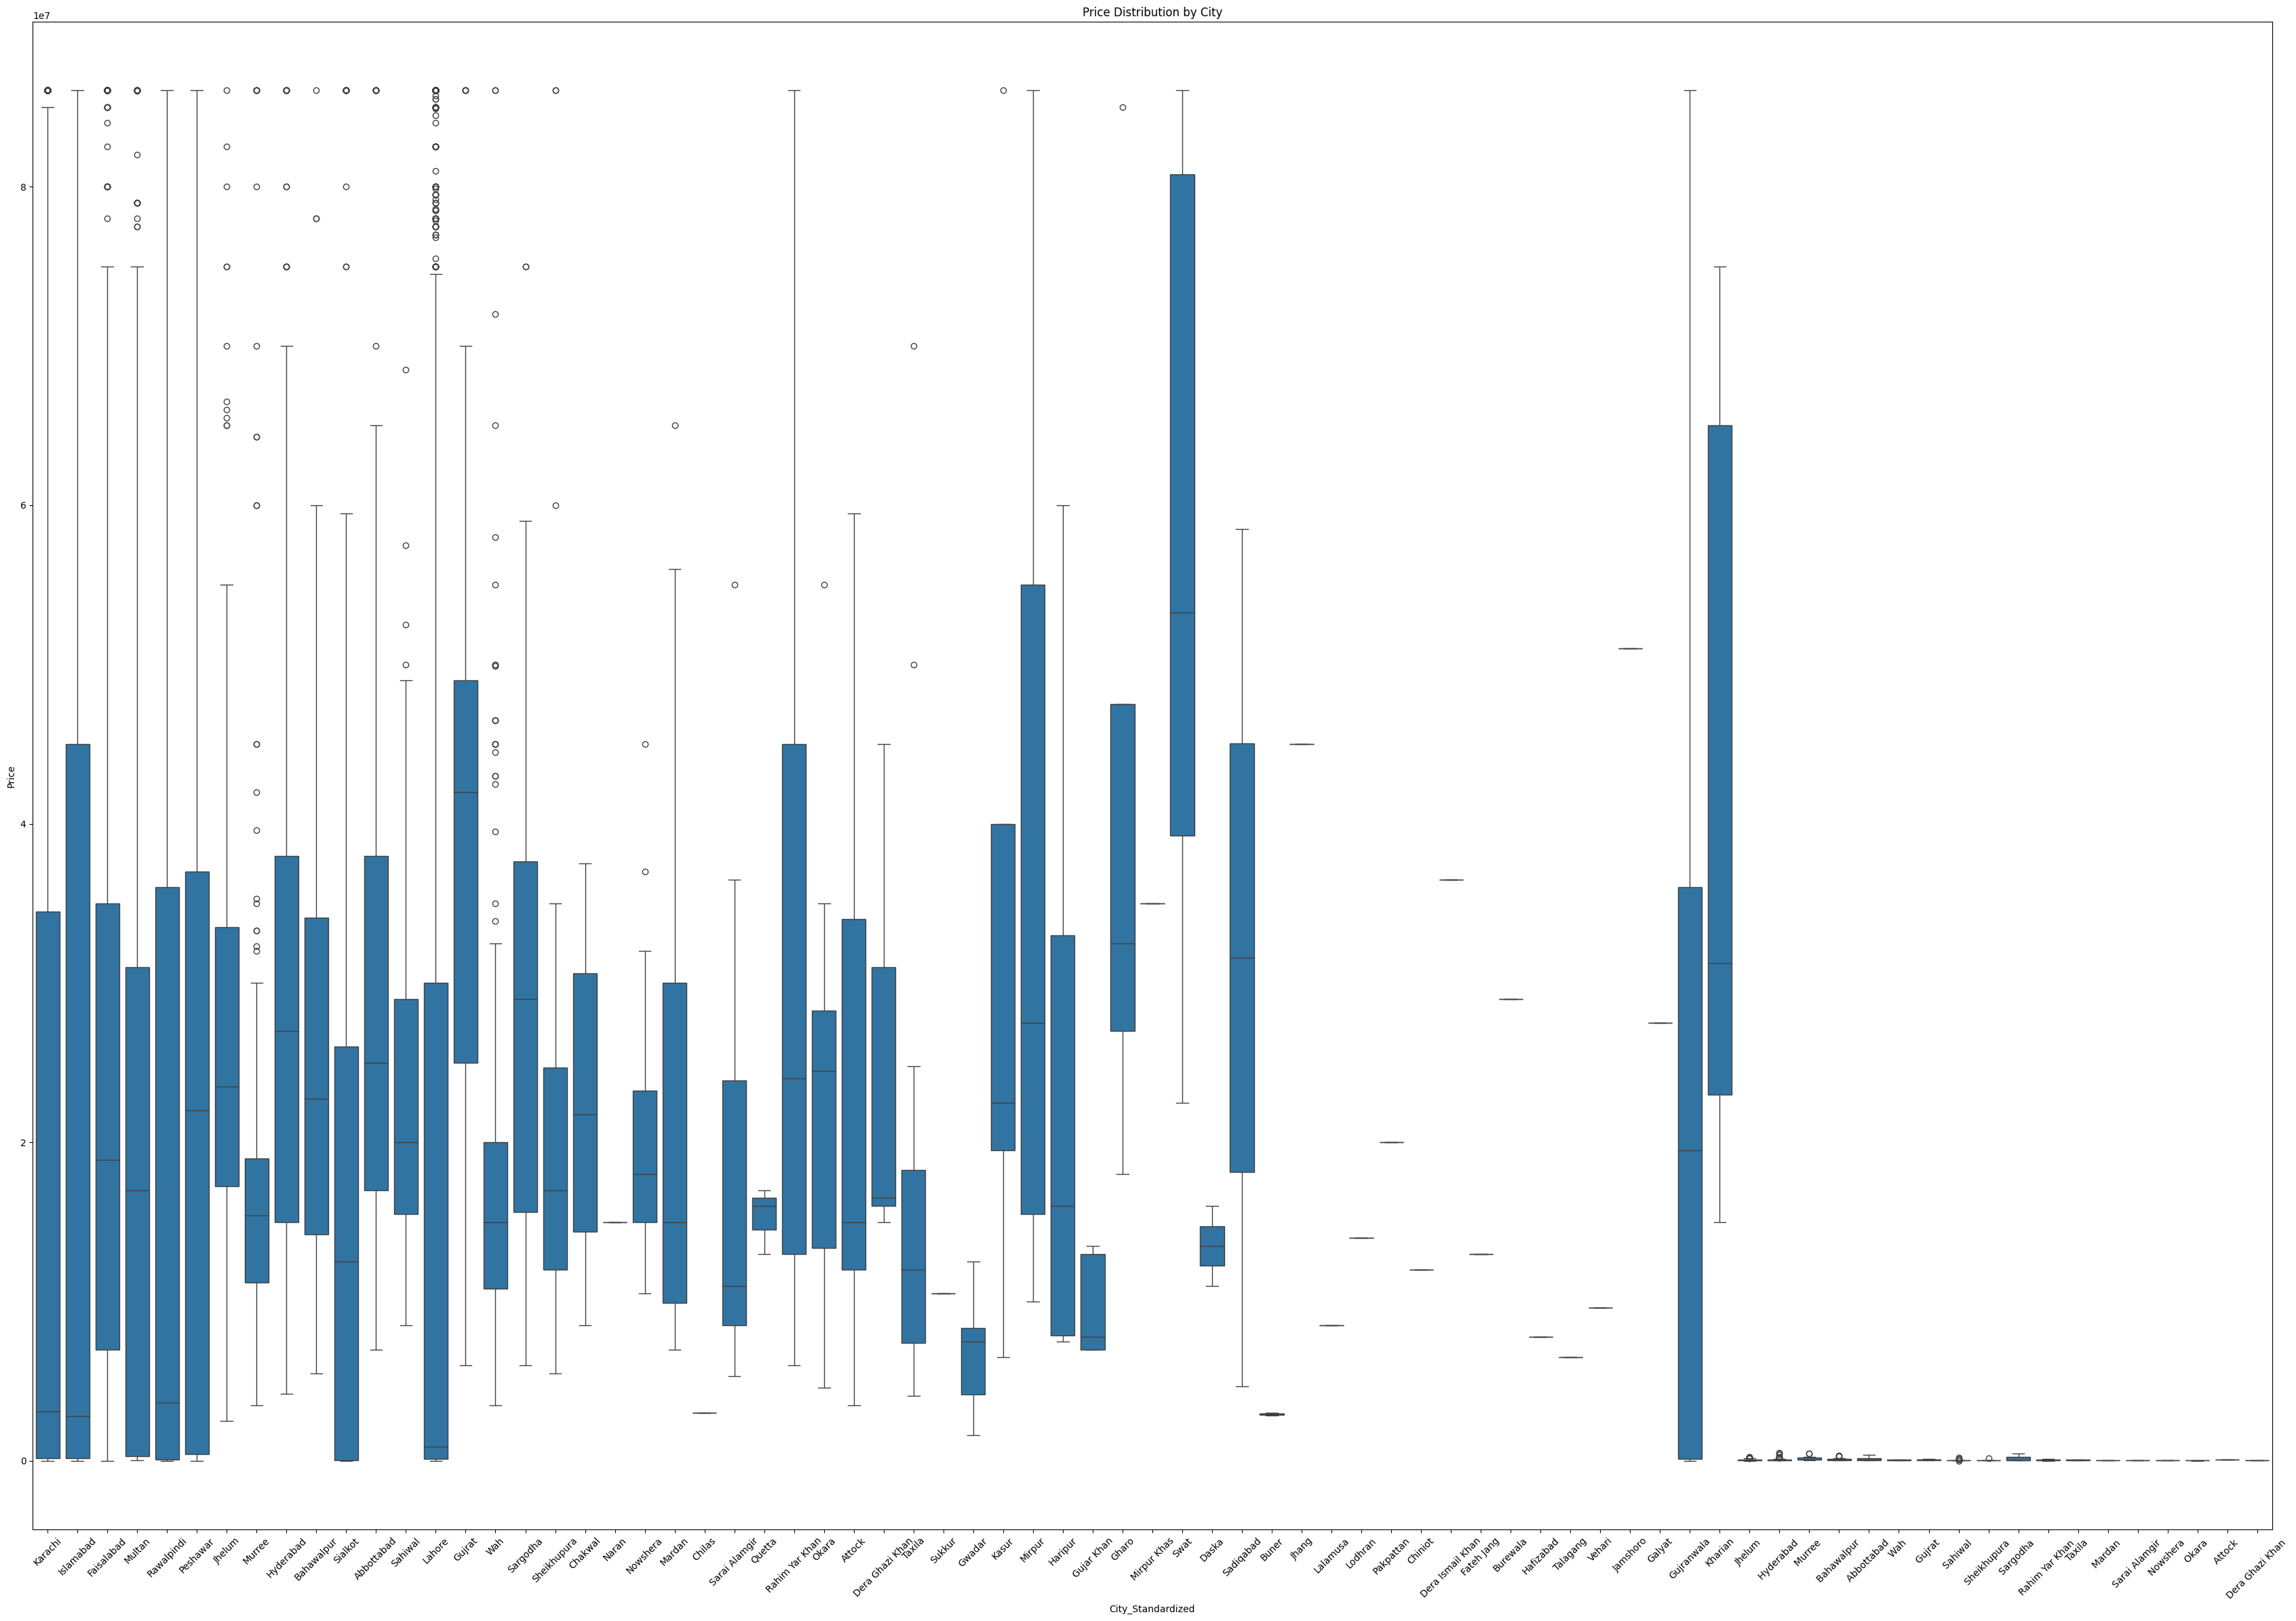

In [270]:
# Price distribution by city
plt.figure(figsize=(34, 24))
sns.boxplot(x=df['City_Standardized'], y=df['Price'])
plt.title('Price Distribution by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

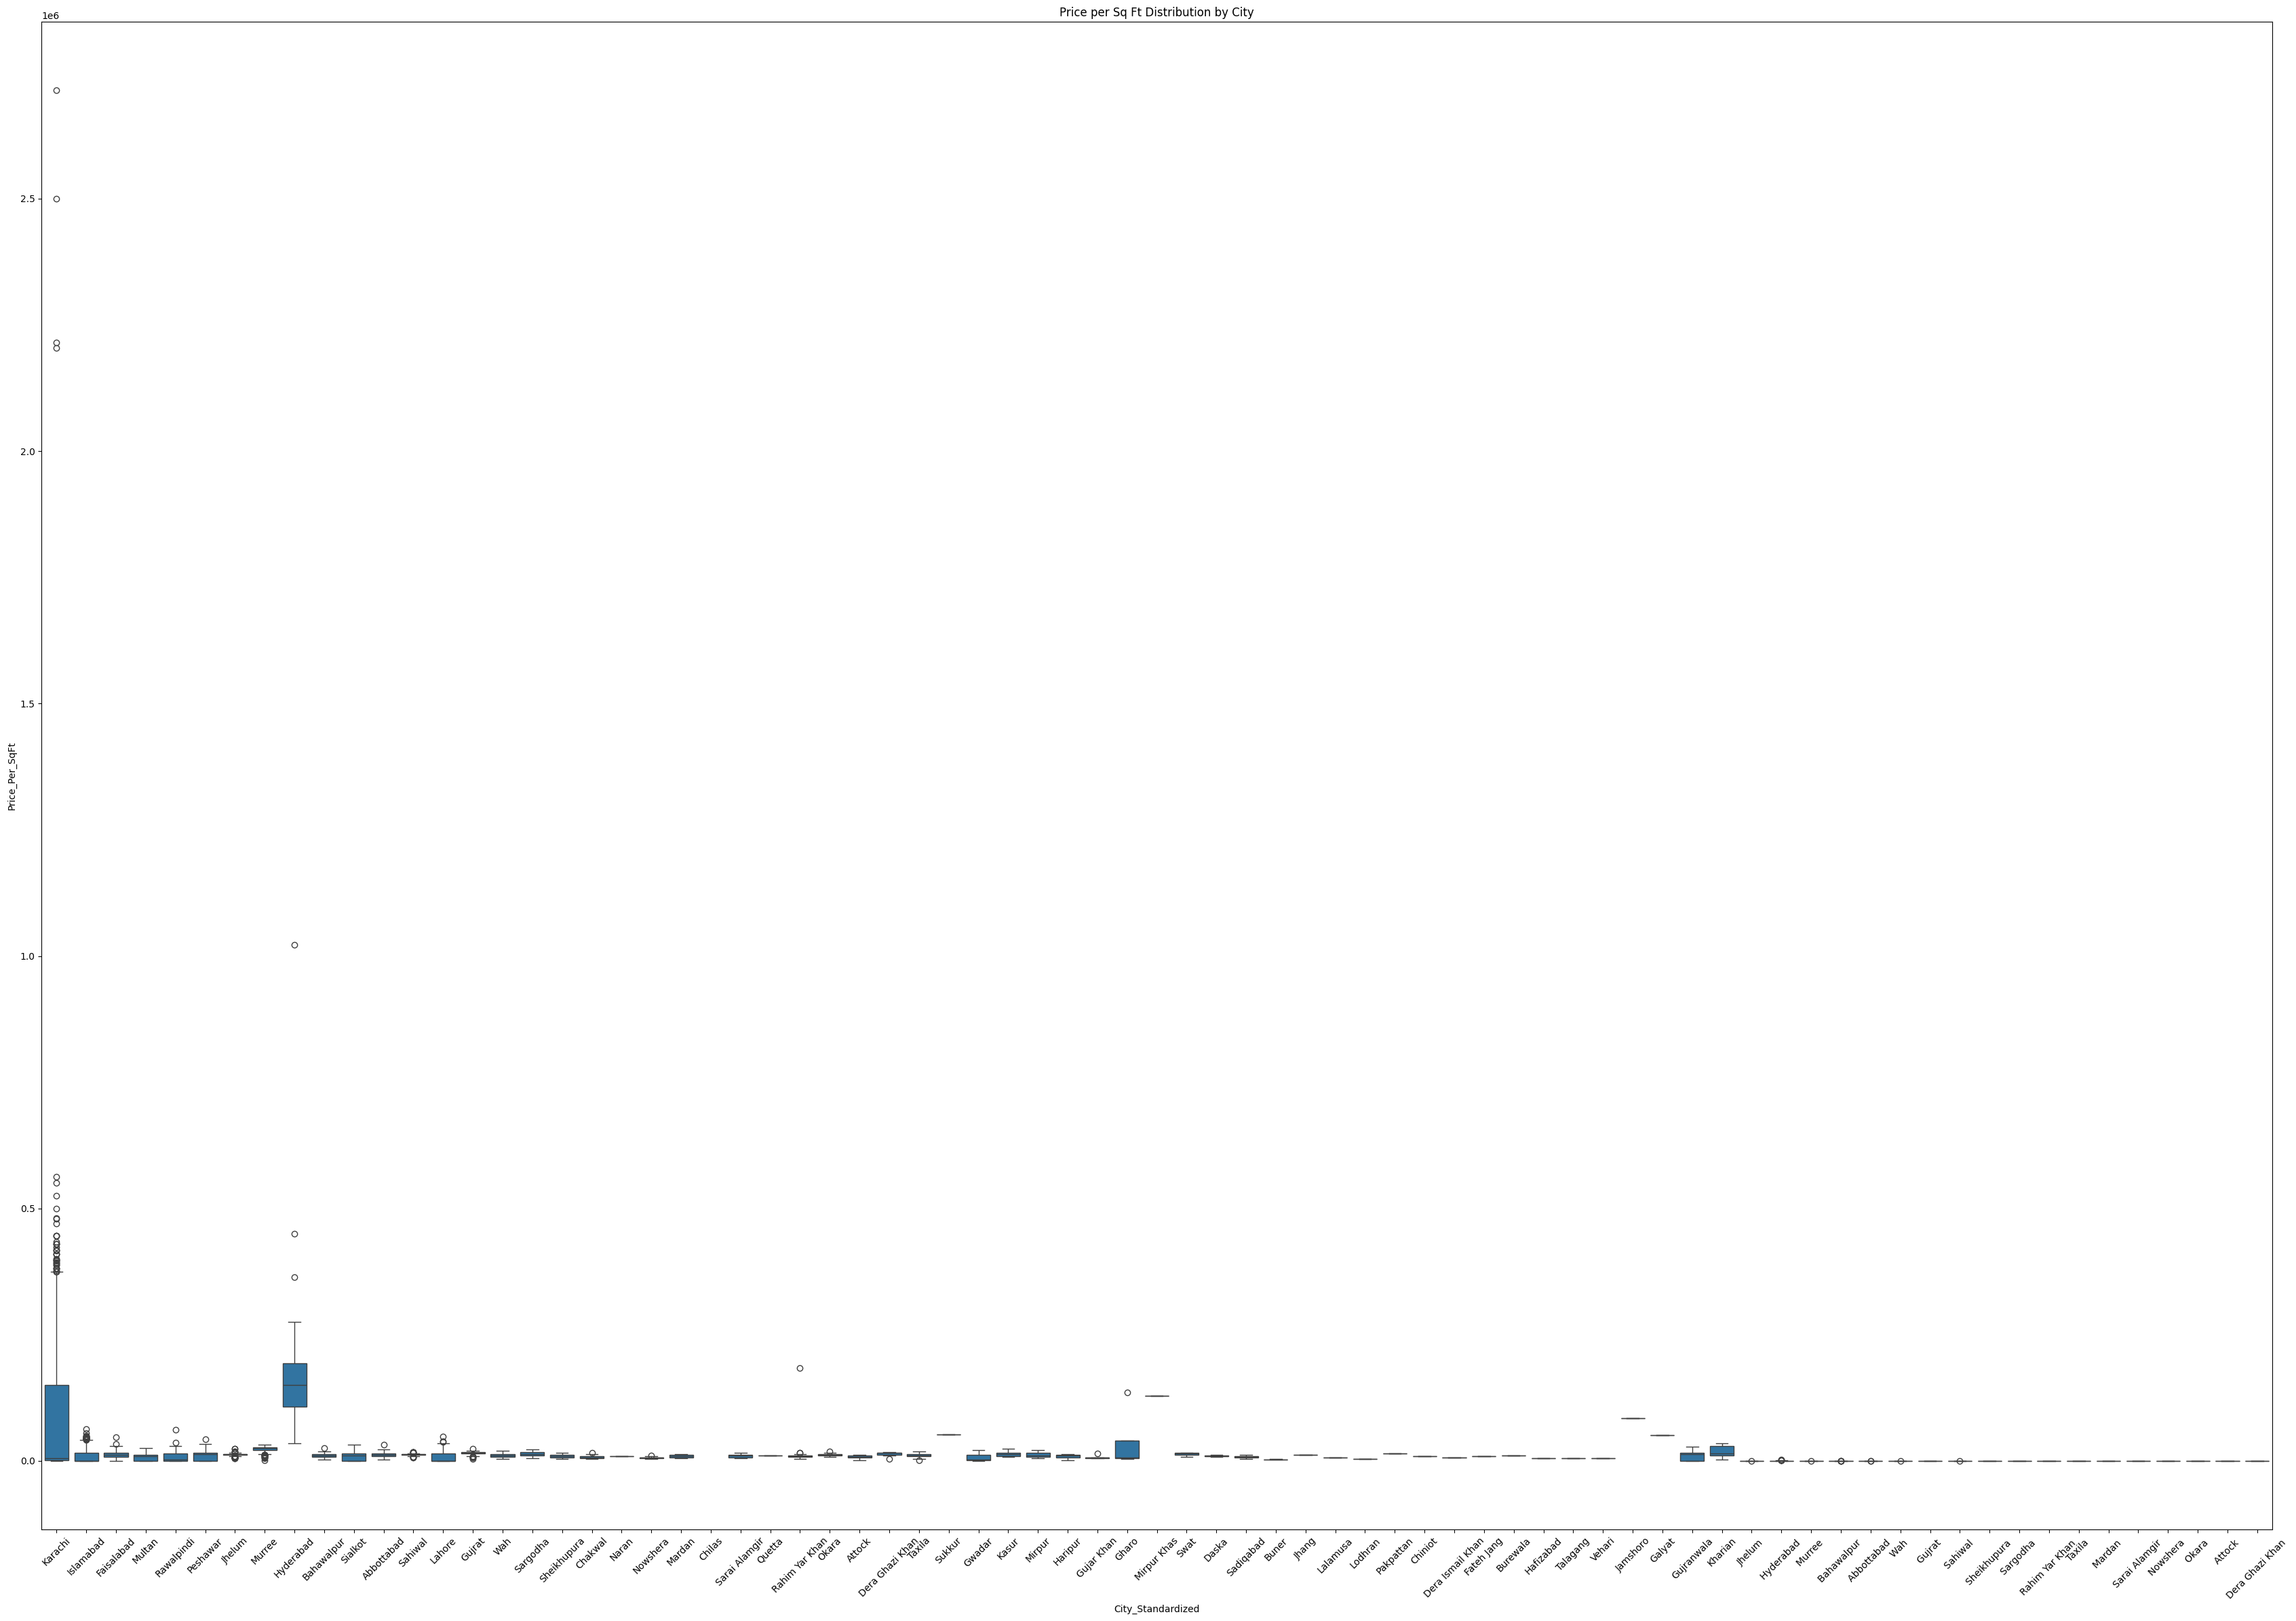

In [271]:
# Price per Sq Ft by city
plt.figure(figsize=(34, 24))
sns.boxplot(x=df['City_Standardized'], y=df['Price_Per_SqFt'])
plt.title('Price per Sq Ft Distribution by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

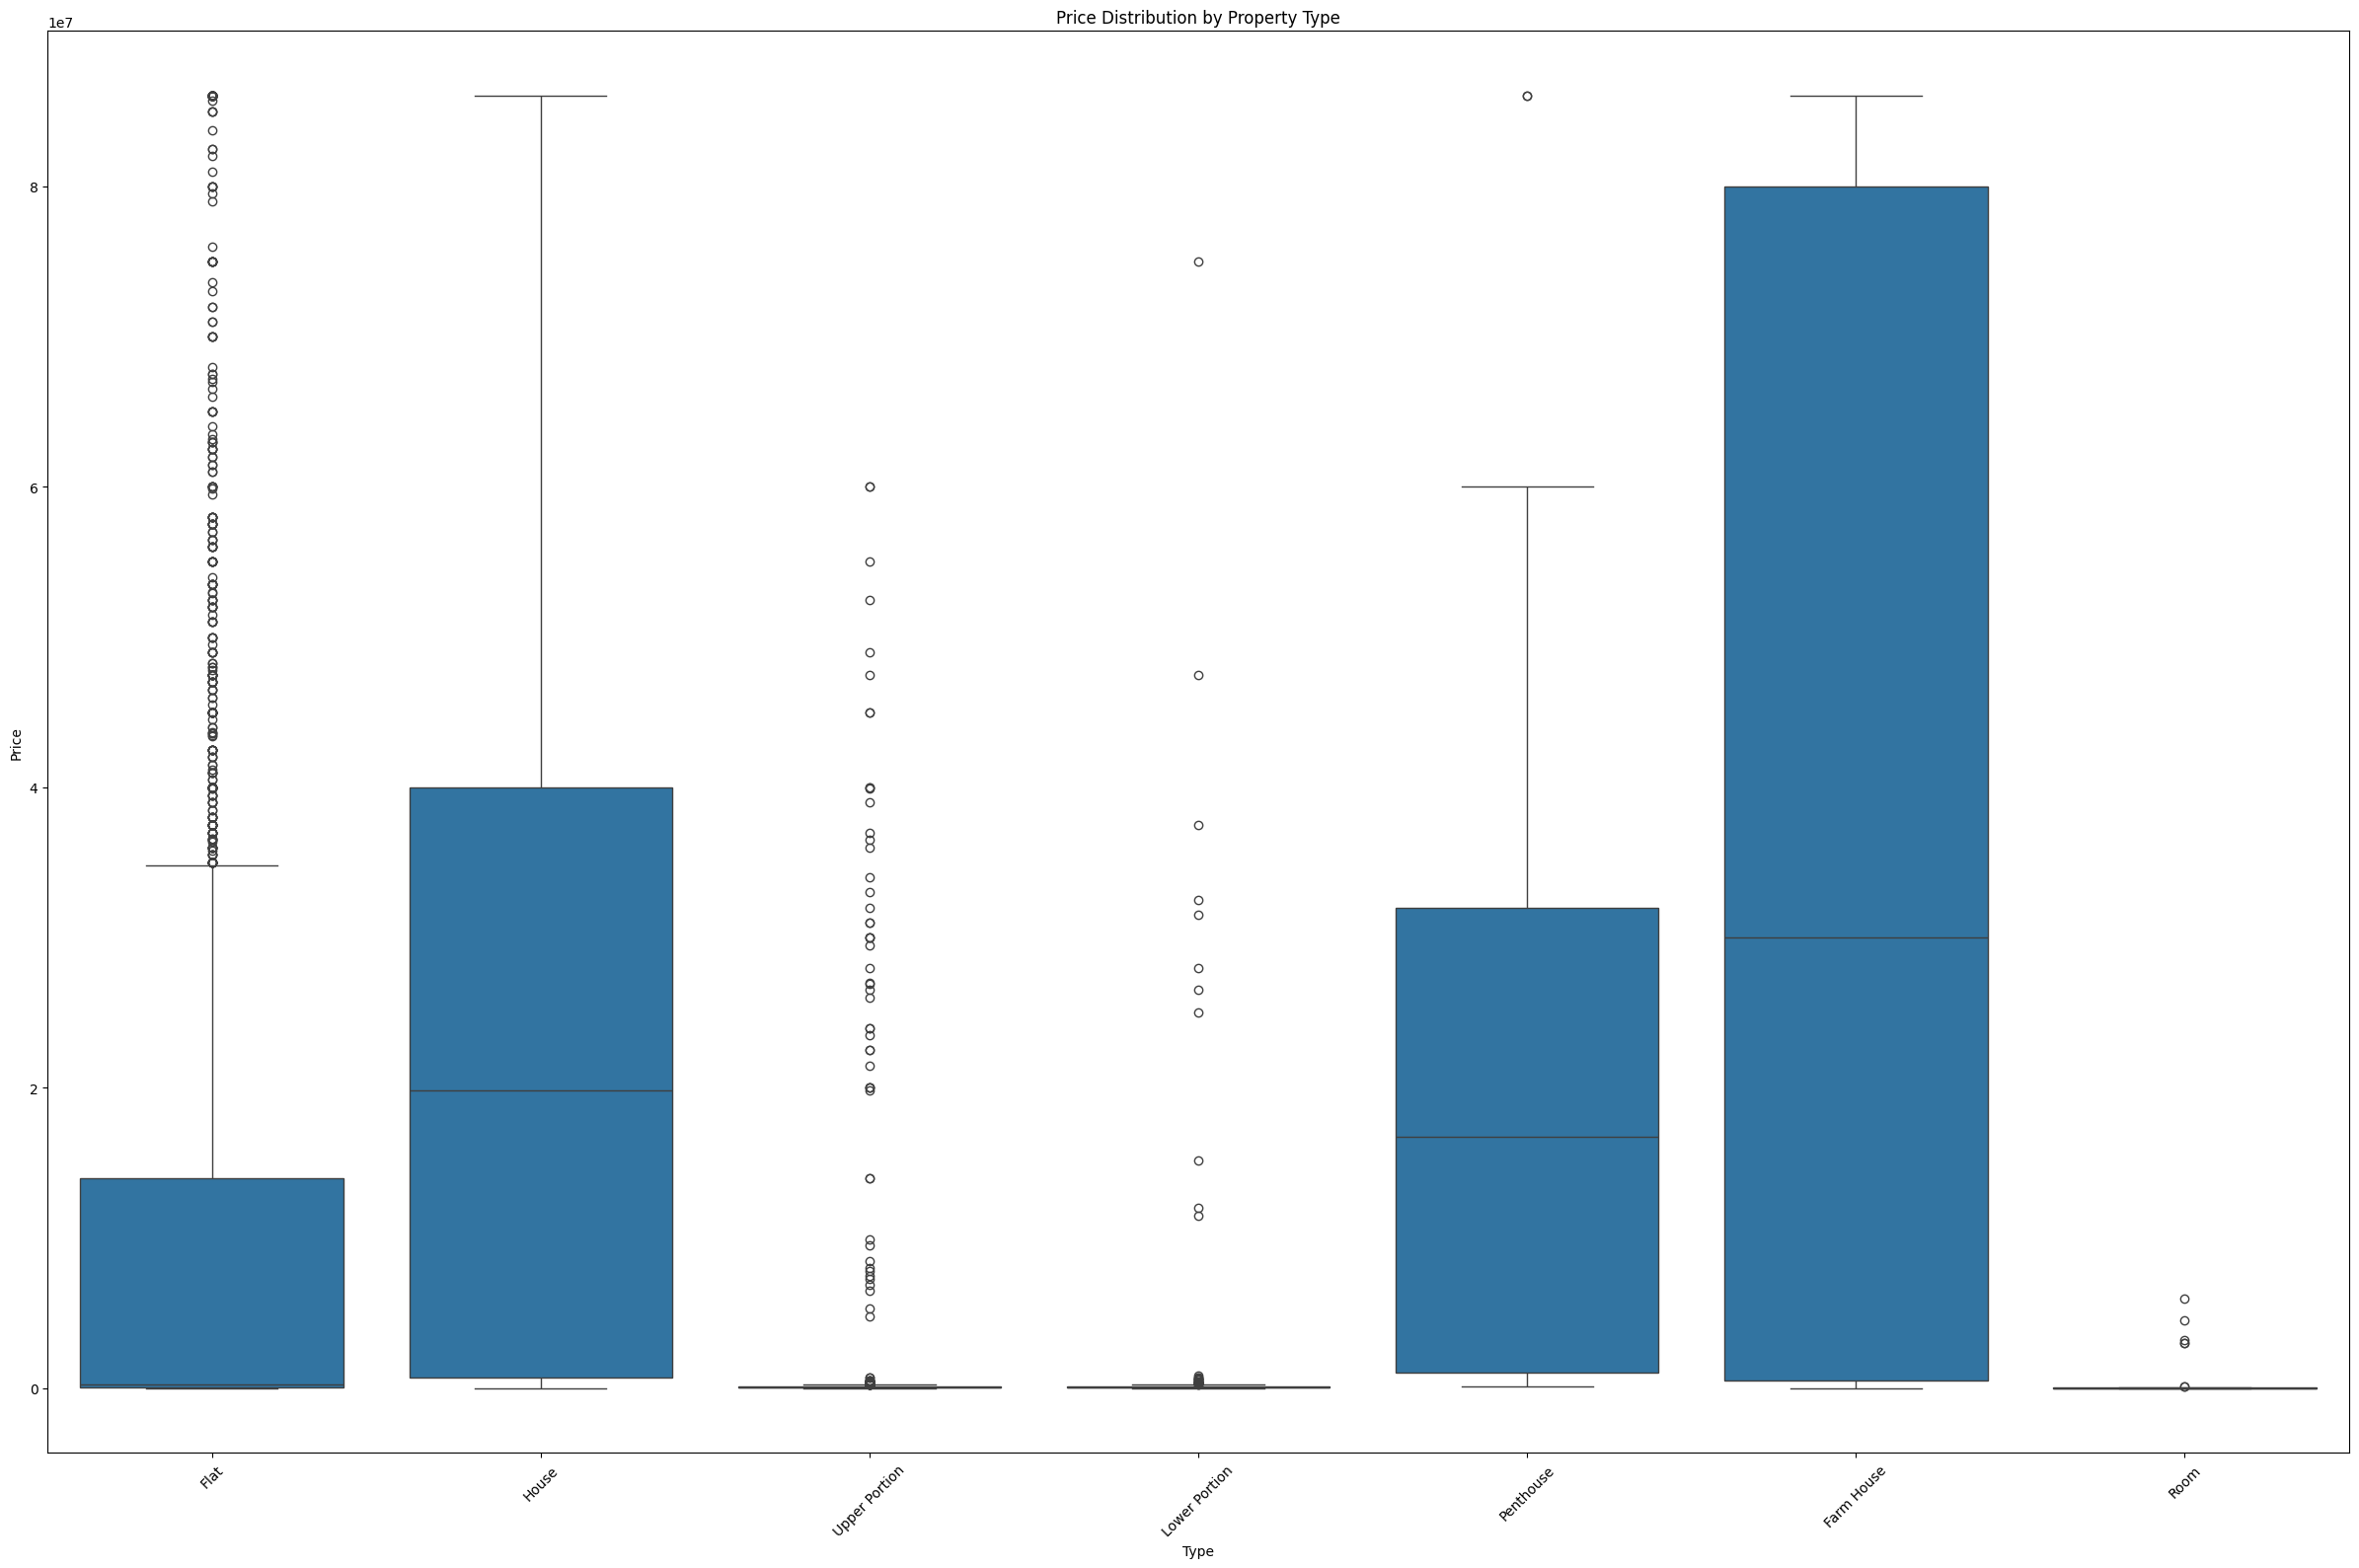

In [272]:
# Price by property type
plt.figure(figsize=(24, 16))
sns.boxplot(x=df['Type'], y=df['Price'])
plt.title('Price Distribution by Property Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

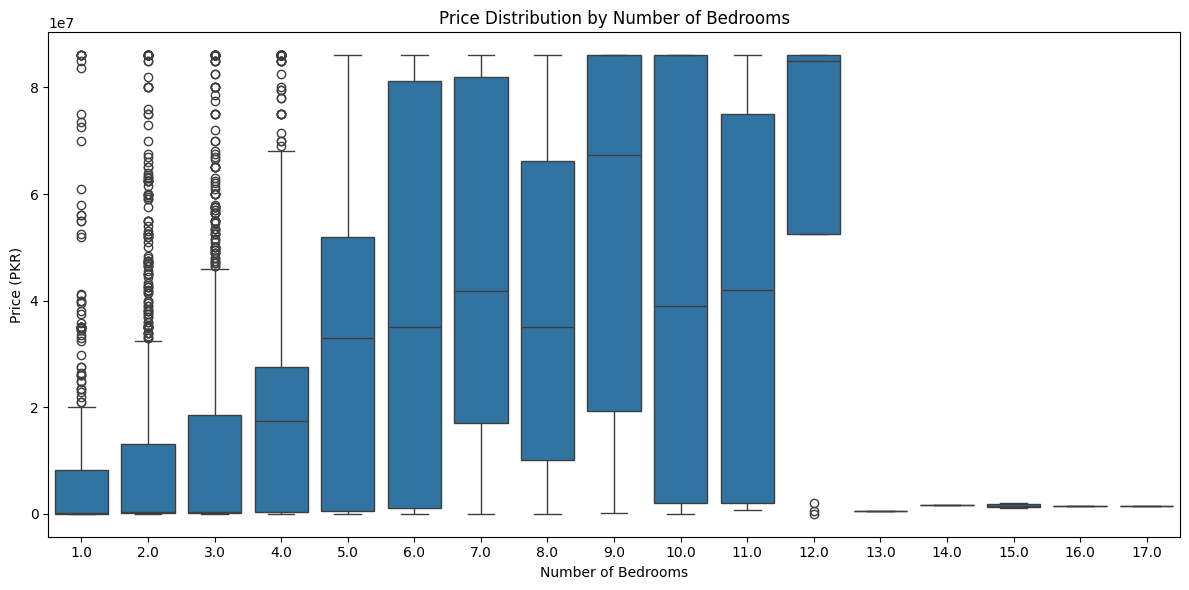

In [273]:
# Price by number of bedrooms
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Bedrooms'], y=df['Price'])
plt.title('Price Distribution by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (PKR)')
plt.tight_layout()
plt.show()

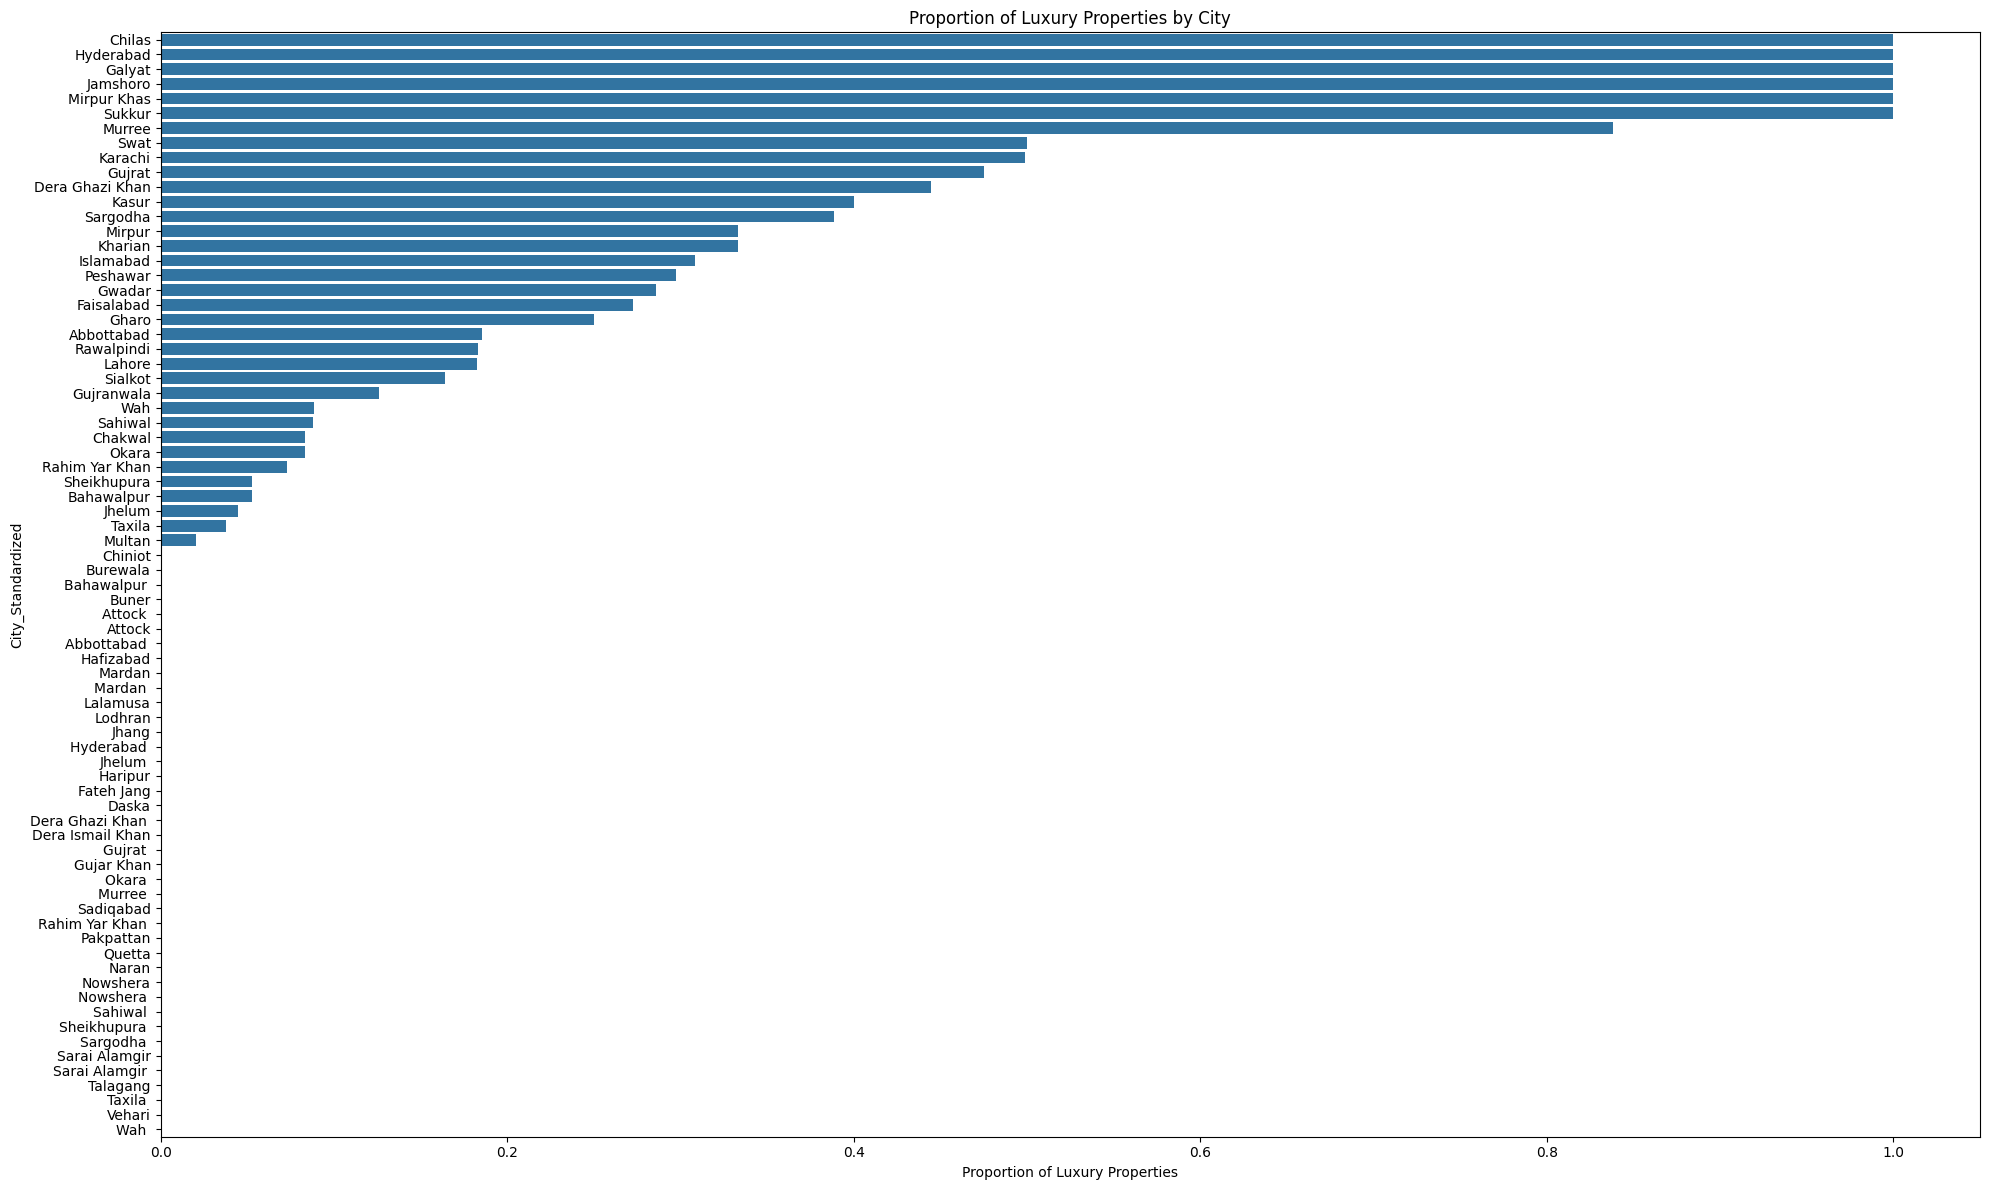

In [274]:
# Luxury property distribution by city
luxury_by_city = df.groupby('City_Standardized')['Luxury_Property'].mean().sort_values(ascending=False)
plt.figure(figsize=(20, 12))
sns.barplot(x=luxury_by_city.values, y=luxury_by_city.index)
plt.title('Proportion of Luxury Properties by City')
plt.xlabel('Proportion of Luxury Properties')
plt.tight_layout()
plt.show()

# **Insights & Recommendations**

In [275]:
# Key insights summary

print("KEY INSIGHTS SUMMARY")

# Overall market summary
print(f"Market Overview:")
print(f"   - Total properties analyzed: {len(df)}")
print(f"   - Average property price: PKR {df['Price'].mean():,.0f}")
print(f"   - Average area: {df['Area_SqFt'].mean():,.0f} sq ft")


KEY INSIGHTS SUMMARY
Market Overview:
   - Total properties analyzed: 18255
   - Average property price: PKR 21,975,975
   - Average area: 2,222 sq ft


In [276]:
# City-wise analysis

print(f"\nCity-wise Analysis:")
city_stats = df.groupby('City_Standardized')['Price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
for city, row in city_stats.iterrows():
    print(f"   - {city}: PKR {row['mean']:,.0f} (avg price), {row['count']} properties")


City-wise Analysis:
   - Swat: PKR 56,596,667 (avg price), 6.0 properties
   - Jamshoro: PKR 51,000,000 (avg price), 1.0 properties
   - Jhang: PKR 45,000,000 (avg price), 1.0 properties
   - Gharo: PKR 42,000,000 (avg price), 4.0 properties
   - Kharian: PKR 41,500,000 (avg price), 6.0 properties
   - Gujrat: PKR 40,027,327 (avg price), 101.0 properties
   - Dera Ismail Khan: PKR 36,500,000 (avg price), 1.0 properties
   - Mirpur: PKR 36,060,000 (avg price), 9.0 properties
   - Mirpur Khas: PKR 35,000,000 (avg price), 2.0 properties
   - Kasur: PKR 34,908,000 (avg price), 5.0 properties
   - Abbottabad: PKR 31,765,155 (avg price), 97.0 properties
   - Sadiqabad: PKR 31,600,000 (avg price), 2.0 properties
   - Hyderabad: PKR 30,159,925 (avg price), 265.0 properties
   - Sargodha: PKR 29,930,556 (avg price), 36.0 properties
   - Burewala: PKR 29,000,000 (avg price), 1.0 properties
   - Rahim Yar Khan: PKR 28,770,244 (avg price), 41.0 properties
   - Galyat: PKR 27,500,000 (avg price), 

In [277]:
print(f"\nProperty Type Analysis:")
prop_stats = df.groupby('Type')['Price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
for prop_type, row in prop_stats.iterrows():
    print(f"   - {prop_type}: PKR {row['mean']:,.0f} (avg price), {row['count']} properties")


Property Type Analysis:
   - Farm House: PKR 39,906,506 (avg price), 89.0 properties
   - House: PKR 27,076,816 (avg price), 13386.0 properties
   - Penthouse: PKR 23,175,409 (avg price), 22.0 properties
   - Flat: PKR 11,221,573 (avg price), 2892.0 properties
   - Upper Portion: PKR 1,239,410 (avg price), 1247.0 properties
   - Lower Portion: PKR 715,275 (avg price), 560.0 properties
   - Room: PKR 482,114 (avg price), 43.0 properties


In [278]:
print(f"\nKey Correlations:")
print(f"   - Price and Area: {df['Price'].corr(df['Area_SqFt']):.2f}")
print(f"   - Price and Bedrooms: {df['Price'].corr(df['Bedrooms']):.2f}")


Key Correlations:
   - Price and Area: 0.33
   - Price and Bedrooms: 0.40


# **Detailed Analysis and Summary is included in PDF File**

# **Fin.**